In [145]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import calendar

In [146]:
#set display format of output from pandas
pd.set_option('display.float_format', lambda x: '%.6f' % x)
#extend chunksize for somes scatter plot
plt.rcParams['agg.path.chunksize'] = 10000

In [197]:
data_types = {
         'Id': np.dtype(int),
         'Store': np.dtype(int),
         'DayOfWeek': 'category',
         #'Date': np.dtype(str), # we will parse it later
         'Sales': np.dtype(int),
         'Customers': np.dtype(int),
         'Open': 'category',
         'Promo': 'category',
         'StateHoliday': np.dtype(str),
         'SchoolHoliday': np.dtype(str)
         }

store_data_types = {
         'Store': np.dtype(int),
         'StoreType': np.dtype(str),
         'Assortment': np.dtype(str),
         'CompetitionDistance': np.dtype('float64'), # to prevent parsing null value
         'CompetitionOpenSinceMonth': np.dtype(str),
         'CompetitionOpenSinceYear': np.dtype(str),
         'Promo2': 'category',
         'Promo2SinceWeek': np.dtype(str),
         'Promo2SinceYear': np.dtype(str),
         'PromoInterval': np.dtype(str)
        }

train = pd.read_csv('input/train.csv', parse_dates=[2], dtype=data_types)
test = pd.read_csv('input/test.csv', parse_dates=[3], dtype=data_types)
store = pd.read_csv('input/store.csv', dtype=store_data_types)

## Data preparing

In [148]:
# train data
# remove the row that shops are closed
train = train[train["Open"] != '0']

In [149]:
# Merge with store data
train = pd.merge(train, store, on='Store')

In [150]:
# Add is Competition
# This feature is to check that on the day of sales on each store will have the competition store openned or not.

SalesAndCompetition = train[['Date','CompetitionOpenSinceYear','CompetitionOpenSinceMonth']]
SalesAndCompetition = SalesAndCompetition.fillna({'CompetitionOpenSinceYear': '9999', 'CompetitionOpenSinceMonth': '99'})
train['isCompetition'] = np.where((SalesAndCompetition.Date.dt.year >= SalesAndCompetition['CompetitionOpenSinceYear'].astype(int)) &
                                                (SalesAndCompetition.Date.dt.month >= SalesAndCompetition['CompetitionOpenSinceMonth'].astype(int)), '1', '0')


In [151]:
# Add is Promo2
# This feature is to check that on the day of sales on each store will adapt the promotion in that month or not.

SalesAndPromo2 = train[['Date','Promo2','Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']]
SalesAndPromo2 = SalesAndPromo2.fillna({'Promo2SinceYear': '9999', 'Promo2SinceWeek': '99', 'PromoInterval': 'None'})
train['isPromo2'] = np.where((SalesAndPromo2.Date.dt.year >= SalesAndPromo2['Promo2SinceYear'].astype(int)) &
                             (SalesAndPromo2.Date.dt.week >= SalesAndPromo2['Promo2SinceWeek'].astype(int))
                             , '1', '0')
train['isPromo2'] = train.apply(lambda x: '1' if x.isPromo2 != '0' and calendar.month_abbr[x.Date.month] in x.PromoInterval else '0', axis=1)



In [152]:
# Extract Year Month Day and WeekOfYear

train['Year'] = train.Date.dt.year
train['Month'] = train.Date.dt.month
train['Day'] = train.Date.dt.day
train['WeekOfYear'] = train.Date.dt.weekofyear

In [153]:
# Transform category values to be integer value

train.loc[train['StateHoliday'] == 'a', 'StateHoliday'] = '1'
train.loc[train['StateHoliday'] == 'b', 'StateHoliday'] = '2'
train.loc[train['StateHoliday'] == 'c', 'StateHoliday'] = '3'
train['StateHoliday'] = train['StateHoliday'].astype(int)

In [154]:
# Transform category values to be integer value

train.loc[train['StoreType'] == 'a', 'StoreType'] = '1'
train.loc[train['StoreType'] == 'b', 'StoreType'] = '2'
train.loc[train['StoreType'] == 'c', 'StoreType'] = '3'
train.loc[train['StoreType'] == 'd', 'StoreType'] = '4'
train['StoreType'] = train['StoreType'].astype(int)

In [155]:
# Transform category values to be integer value

train.loc[train['Assortment'] == 'a', 'Assortment'] = '1'
train.loc[train['Assortment'] == 'b', 'Assortment'] = '2'
train.loc[train['Assortment'] == 'c', 'Assortment'] = '3'
train['Assortment'] = train['Assortment'].astype(int)

In [156]:
# Some stores do not have competition so we will replace null value with 0 

train.CompetitionDistance.fillna(0, inplace=True)

## Model evaluation function

In [157]:
# init function RMSPE for evaluation the accuracy
def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

## Model training with all features

In [158]:
# Select all important features.
train2 = train[train["Open"] != 0]
pre_train = train2[(train['Date'].dt.year <= 2015) & (train['Date'].dt.month < 7)]
pre_test = train2[(train['Date'].dt.year >= 2015) & (train['Date'].dt.month >= 7)]

X_train = pre_train[['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
                    'Assortment', 'CompetitionDistance', 'isCompetition', 'isPromo2', 'Year', 'Month', 'Day', 'WeekOfYear']]
X_test = pre_test[['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
                    'Assortment', 'CompetitionDistance', 'isCompetition', 'isPromo2', 'Year', 'Month', 'Day', 'WeekOfYear']]

y_train = pre_train[['Sales']]
y_test = pre_test[['Sales']]

#X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.2, random_state=0)


## Linear regression

In [159]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [160]:
# The Polynomial linear model with degree = 1 is the same as simple linear regression

polynomial_features = PolynomialFeatures(degree=1,
                                             include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.35868801489314656

In [161]:
# The Polynomial linear model with degree = 2
polynomial_features = PolynomialFeatures(degree=2,
                                             include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.3495038608333047

In [162]:
# The Polynomial linear model with degree = 3
polynomial_features = PolynomialFeatures(degree=3,
                                             include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.7251150776212459

In [163]:
# Ridge Regression with alpha 0.05

ridge_reg_05 = Ridge(alpha=0.05, normalize=False)
ridge_reg_05.fit(X_train, y_train.values.ravel())

y_pred = ridge_reg_05.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.3586877853374594

In [164]:
# Ridge Regression with alpha 1

ridge_reg_1 = Ridge(alpha=1, normalize=False)
ridge_reg_1.fit(X_train, y_train.values.ravel())

y_pred = ridge_reg_1.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.3586834431323611

In [165]:
# Ridge Regression with alpha 10

ridge_reg_10 = Ridge(alpha=10, normalize=True)
ridge_reg_10.fit(X_train, y_train.values.ravel())

y_pred = ridge_reg_10.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.4115152261642876

In [166]:
# Lasso Regression with alpha 0.05

lasso_reg_05 = Lasso(alpha=0.05, normalize=False)
lasso_reg_05.fit(X_train, y_train.values.ravel())

y_pred = lasso_reg_05.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)


D:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.3578801810082475

In [167]:
# Lasso Regression with alpha 1

lasso_reg_1 = Lasso(alpha=1, normalize=False)
lasso_reg_1.fit(X_train, y_train.values.ravel())

y_pred = lasso_reg_1.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)


D:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.357768042153542

In [168]:
# Lasso Regression with alpha 10

lasso_reg_10 = Lasso(alpha=10, normalize=False)
lasso_reg_10.fit(X_train, y_train.values.ravel())

y_pred = lasso_reg_10.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)


0.3584050987641705

In [170]:
# Elastic Net Regression with alpha 0.05

EN_reg_05 = ElasticNet(alpha=0.05, l1_ratio=0.5, normalize=False)
EN_reg_05.fit(X_train, y_train.values.ravel())

y_pred = EN_reg_05.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.3580386145978764

In [171]:
# Elastic Net Regression with alpha 1

EN_reg_1 = ElasticNet(alpha=1, l1_ratio=0.5, normalize=False)
EN_reg_1.fit(X_train, y_train.values.ravel())

y_pred = EN_reg_1.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.3768120789210284

In [172]:
# Elastic Net Regression with alpha 10

EN_reg_10 = ElasticNet(alpha=10, l1_ratio=0.5, normalize=False)
EN_reg_10.fit(X_train, y_train.values.ravel())

y_pred = EN_reg_10.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.4003992067081737

## Ensemble method

In [173]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

In [174]:
#Extra Tree Regressor
model_ET = ExtraTreesRegressor(n_jobs = -1, n_estimators = 10)
model_ET.fit(X_train, y_train.values.ravel())

y_pred = model_ET.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.2490201203170259

In [175]:
#Random Forest Regressor with max depth = 3
model_RF_3 = RandomForestRegressor(max_depth=3, n_estimators=10, random_state=0)
model_RF_3.fit(X_train, y_train.values.ravel())

y_pred = model_RF_3.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.3820557254306466

In [176]:
#Random Forest Regressor
model_RF = RandomForestRegressor(n_jobs = -1, n_estimators=10)
model_RF.fit(X_train, y_train.values.ravel())

y_pred = model_RF.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.19712882347043972

In [177]:
#Ada Boost Regressor
model_AB = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=10)
model_AB.fit(X_train, y_train.values.ravel())

y_pred = model_AB.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.19382541171583267

## Model training with top 5 important features

In [178]:
# Select all important features.
train = train[train["Open"] != 0]
pre_train = train[(train['Date'].dt.year <= 2015) & (train['Date'].dt.month < 7)]
pre_test = train[(train['Date'].dt.year >= 2015) & (train['Date'].dt.month >= 7)]

X_train = pre_train[['Store', 'CompetitionDistance', 'Promo', 'DayOfWeek', 'StoreType' ]]
X_test = pre_test[['Store', 'CompetitionDistance', 'Promo', 'DayOfWeek', 'StoreType' ]]

y_train = pre_train[['Sales']]
y_test = pre_test[['Sales']]

## Linear regression

In [179]:
# The Polynomial linear model with degree = 1 is the same as simple linear regression

polynomial_features = PolynomialFeatures(degree=1,
                                             include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.3959807605492311

In [180]:
# The Polynomial linear model with degree = 2
polynomial_features = PolynomialFeatures(degree=2,
                                             include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.3928170951322243

In [181]:
# The Polynomial linear model with degree = 3
polynomial_features = PolynomialFeatures(degree=3,
                                             include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.38414154736488937

In [182]:
# Ridge Regression with alpha 0.05

ridge_reg2 = Ridge(alpha=0.05, normalize=False)
ridge_reg2.fit(X_train, y_train.values.ravel())

y_pred = ridge_reg2.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.3959807533325875

In [183]:
# Ridge Regression with alpha 1

ridge_reg2_1 = Ridge(alpha=1, normalize=False)
ridge_reg2_1.fit(X_train, y_train.values.ravel())

y_pred = ridge_reg2_1.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.3959806162210278

In [184]:
# Ridge Regression with alpha 10

ridge_reg2_10 = Ridge(alpha=10, normalize=True)
ridge_reg2_10.fit(X_train, y_train.values.ravel())

y_pred = ridge_reg2_10.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.4194546692831167

In [185]:
# Lasso Regression with alpha 0.05

lasso_reg2_05 = Lasso(alpha=0.05, normalize=False)
lasso_reg2_05.fit(X_train, y_train.values.ravel())

y_pred = lasso_reg2_05.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)


0.39597931074121356

In [186]:
# Lasso Regression with alpha 1

lasso_reg2_1 = Lasso(alpha=1, normalize=False)
lasso_reg2_1.fit(X_train, y_train.values.ravel())

y_pred = lasso_reg2_1.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)


0.3959519440535054

In [187]:
# Lasso Regression with alpha 10

lasso_reg2_10 = Lasso(alpha=10, normalize=False)
lasso_reg2_10.fit(X_train, y_train.values.ravel())

y_pred = lasso_reg2_10.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)


0.39570970364913893

In [188]:
# Elastic Net Regression with alpha 0.05

EN_reg2_05 = ElasticNet(alpha=0.05, l1_ratio=0.5, normalize=False)
EN_reg2_05.fit(X_train, y_train.values.ravel())

y_pred = EN_reg2_05.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.394815091131475

In [189]:
# Elastic Net Regression with alpha 1

EN_reg2_1 = ElasticNet(alpha=1, l1_ratio=0.5, normalize=False)
EN_reg2_1.fit(X_train, y_train.values.ravel())

y_pred = EN_reg2_1.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.4050289273604949

In [190]:
# Elastic Net Regression with alpha 10

EN_reg2_10 = ElasticNet(alpha=10, l1_ratio=0.5, normalize=False)
EN_reg2_10.fit(X_train, y_train.values.ravel())

y_pred = EN_reg2_10.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.42073698897236356

## Ensemble method

In [191]:
#Extra Tree Regressor
model_ET2 = ExtraTreesRegressor(n_jobs = -1, n_estimators = 10)
model_ET2.fit(X_train, y_train.values.ravel())

y_pred = model_ET2.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.16391290928369787

In [193]:
#Random Forest Regressor with max depth = 3
model_RF2_3 = RandomForestRegressor(max_depth=3, n_estimators=10, random_state=0)
model_RF2_3.fit(X_train, y_train.values.ravel())

y_pred = model_RF2_3.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.3891467625582601

In [194]:
#Random Forest Regressor
model_RF2 = RandomForestRegressor(n_jobs = -1, n_estimators = 10)
model_RF2.fit(X_train, y_train.values.ravel())

y_pred = model_RF2.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.1642898943200055

In [195]:
#Ada Boost Regressor
model_AB2 = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=10)
model_AB2.fit(X_train, y_train.values.ravel())

y_pred = model_AB2.predict(X_test)

rmspe(y_test.values.ravel(), y_pred)

0.1643298966033227

So we will use random forest algorithm with top 5 features to predict the test data.

# Predicting test data

## Data preparing

In [135]:
test = pd.merge(test, store, on='Store')
test.loc[test.Open.isnull(), 'Open'] = '1'

In [136]:
test.CompetitionDistance.fillna(0, inplace=True)

In [137]:
# Transform category values to be integer value

test.loc[test['StoreType'] == 'a', 'StoreType'] = '1'
test.loc[test['StoreType'] == 'b', 'StoreType'] = '2'
test.loc[test['StoreType'] == 'c', 'StoreType'] = '3'
test.loc[test['StoreType'] == 'd', 'StoreType'] = '4'
test['StoreType'] = test['StoreType'].astype(int)

In [138]:
test_data = test[['Store', 'CompetitionDistance', 'Promo', 'DayOfWeek', 'StoreType' ]]

In [139]:
test_data.head()

,Store,CompetitionDistance,Promo,DayOfWeek,StoreType
0,1,1270.000000,1,4,3
1,1,1270.000000,1,3,3
2,1,1270.000000,1,2,3
3,1,1270.000000,1,1,3
4,1,1270.000000,0,7,3


## Prediction

In [198]:
test_y_pred = model_RF2.predict(test_data)

In [199]:
test['Sales'] = test_y_pred

In [200]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Sales
0,1,1,4,2015-09-17,1,1,0,0,4868.950572
1,2,3,4,2015-09-17,1,1,0,0,5077.300763
2,3,7,4,2015-09-17,1,1,0,0,5367.862856
3,4,8,4,2015-09-17,1,1,0,0,5883.651148
4,5,9,4,2015-09-17,1,1,0,0,4763.917618


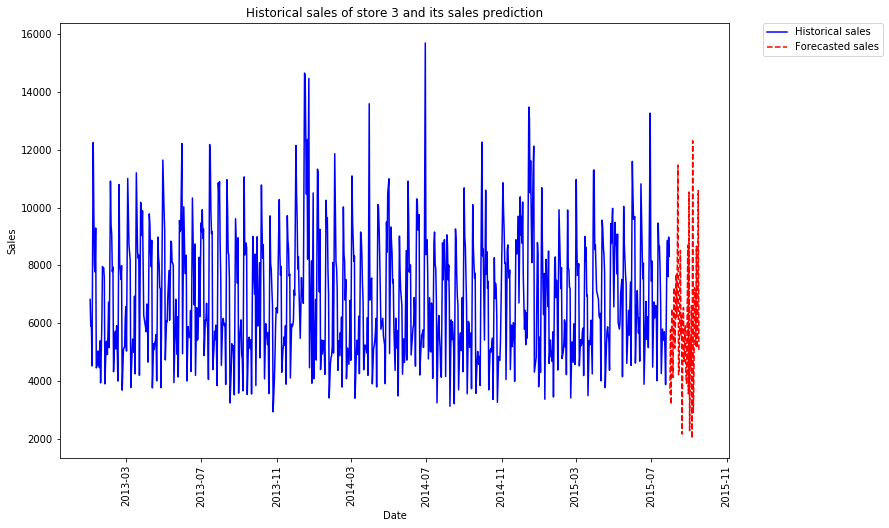

In [201]:
# The red line is the sales trend from test data, a.k.a. sales forecasting

sales_store3 = train[['Date','Sales']][(train['Store'] == 3) & (train['Open'] == '1')]
sales_store3_predict = test[['Date','Sales']][test['Store'] == 3]

plt.figure(figsize=(12, 8))
plt.plot(pd.to_datetime(sales_store3.Date), sales_store3.Sales, '-b', label='Historical sales')
plt.plot(pd.to_datetime(sales_store3_predict.Date), sales_store3_predict.Sales, '--r', label='Forecasted sales')

plt.ylabel('Sales')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=90)
plt.title('Historical sales of store 3 and its sales prediction')
plt.show()

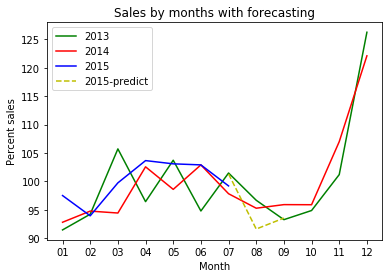

In [202]:
# The yellow line is the sales trend from test data, a.k.a. sales forecasting

saleAndDate = train[['Sales','Date']][train['Sales'] != 0]
saleByMonth2013 = saleAndDate[saleAndDate['Date'].dt.year == 2013].groupby(saleAndDate['Date'].dt.strftime('%m'))['Sales'].mean().sort_index(level="Date", ascending=True)
saleByMonth2014 = saleAndDate[saleAndDate['Date'].dt.year == 2014].groupby(saleAndDate['Date'].dt.strftime('%m'))['Sales'].mean().sort_index(level="Date", ascending=True)
saleByMonth2015 = saleAndDate[saleAndDate['Date'].dt.year == 2015].groupby(saleAndDate['Date'].dt.strftime('%m'))['Sales'].mean().sort_index(level="Date", ascending=True)
saleByMonth2015_test = test.groupby(test['Date'].dt.strftime('%m'))['Sales'].mean().sort_index(level="Date", ascending=True)
saleByMonth2015_predict = saleByMonth2015.append(saleByMonth2015_test)


plt.plot(saleByMonth2013.keys(), (saleByMonth2013 / np.mean(saleByMonth2013)) * 100, '-g', label = '2013')
plt.plot(saleByMonth2014.keys(), (saleByMonth2014 / np.mean(saleByMonth2014)) * 100, '-r', label = '2014')
plt.plot(saleByMonth2015.keys(), (saleByMonth2015 / np.mean(saleByMonth2015)) * 100, '-b', label = '2015')
plt.plot(saleByMonth2015_predict.iloc[6:9].keys(), ((saleByMonth2015_predict / np.mean(saleByMonth2015_predict)) * 100)[6:9],
'--y', label = '2015-predict')

plt.xlabel('Month')
plt.ylabel('Percent sales')
plt.title('Sales by months with forecasting')
plt.legend()
plt.show()